In [3]:
import pymongo
import pandas as pd

In [22]:
import numpy as np

In [4]:
conn = pymongo.MongoClient(
 
)

In [5]:
db = conn['indigo']
apt_col = db['apartments']

In [7]:
apt_col.count_documents({
    'city':'上海',
    'missing_info':False
})

590988

In [11]:
apts = apt_col.find({
  '$query':{
    'city':'上海',
    'missing_info':False
     
  },
    '$orderby':{
        'created_at':1
    }
},
    {
        'computed':0,
        'check_in_date':0,
        'house_url':0,
        'created_time':0,
        'updated_time':0,
        'house_code':0,
        'house_id':0,
        'city_abbreviation':0,
        'community_deals':0,
        'community_url':0,
        'geo_info':0,
        'house_description':0,
        'lease':0,
        'missing_info':0,
        'price_per_square_meter':0,
        'title':0,
        'coordinates':0,
        'coordtype':0,
        'updated_at':0
    }
)

In [12]:
apts = list(apts)

In [13]:
len(apts)

590988

In [14]:
df = pd.DataFrame(apts)

In [15]:
df.head()

,_id,station_ids,line_ids,air_condition,area,bed,bizcircle,building_total_floors,carport,city,...,washing_machine,water,water_heater,wifi,force_pass,missing_keys,notified,notification_sent,checked_times,expired
0,5e1d6821d0a007c24e35aa10,[100022007],[143685064],1,20.0,1,九亭,6,租用车位,上海,...,1,暂无数据,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,5e1d681dd0a007c24e35aa0a,[100022007],[143685064],1,24.0,1,九亭,6,租用车位,上海,...,1,暂无数据,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,5e42a377ae438c9c2e2fed84,NaN,NaN,1,30.0,1,西郊,6,暂无数据,上海,...,1,民水,1,1,True,NaN,NaN,NaN,NaN,NaN
3,5e42a376ae438c9c2e2fed82,NaN,NaN,1,40.0,1,西郊,6,租用车位,上海,...,1,暂无数据,1,1,True,NaN,NaN,NaN,NaN,NaN
4,5e42a375ae438c9c2e2fed80,NaN,NaN,1,38.0,1,西郊,7,租用车位,上海,...,1,民水,1,1,True,NaN,NaN,NaN,NaN,NaN


In [17]:
df = df.drop(['missing_keys','force_pass','notified','notification_sent','checked_times','expired'],axis=1)

In [20]:
df.columns

Index(['_id', 'station_ids', 'line_ids', 'air_condition', 'area', 'bed',
       'bizcircle', 'building_total_floors', 'carport', 'city', 'closet',
       'community_name', 'created_at', 'district', 'electricity',
       'electricity_type', 'elevator', 'floor', 'floor_accessibility',
       'floor_full_info', 'fridge', 'gas', 'heating', 'house_type', 'img_urls',
       'lat', 'lng', 'natural_gas', 'orient', 'price', 'subway_accessibility',
       'tags', 'television', 'transportations', 'type', 'version',
       'washing_machine', 'water', 'water_heater', 'wifi'],
      dtype='object')

In [32]:
df.to_csv('./apts.csv')

In [45]:
df['station_ids'] = df[~df['station_ids'].isnull()]['station_ids'].apply(lambda x: len(x))

In [49]:
df['line_ids'] = df[~df['line_ids'].isnull()]['line_ids'].apply(lambda x: len(x))

In [265]:
df_t = df.copy()

In [266]:
df_t = df_t.drop(['_id','img_urls','version','electricity_type','transportations'],axis=1)

In [267]:
df_t = df_t.drop(df_t[df_t['price']<500].index)
df_t = df_t.drop(df_t[df_t['price']>100_000].index)

In [268]:
df_t['tags'] = df_t[~df_t['tags'].isnull()]['tags'].apply(lambda x: ' '.join(x))

In [269]:
## process building_total_floors
def process_b_t_f(v):
    if v == '暂无数据':
        return None
    return int(v)
df_t['building_total_floors'] = df_t['building_total_floors'].apply(process_b_t_f)

In [270]:
# process floor
def process_floor(v):
    if v in ['暂无数据','未知']:
        return None
    if v in ['地下室','地下']:
        return -1
    if v == '低楼层':
        return 3
    if v =='中楼层':
        return 7
    if v == '高楼层':
        return 10
    return int(v)

df_t['floor'] = df_t['floor'].apply(process_floor)

In [271]:
df_t['price'] = np.log(df_t['price'])

In [272]:
df_t['price'].max(), df_t['price'].min()

(11.512925464970229, 6.396929655216146)

In [274]:
len(df_t.columns),len(df_t)

(35, 590608)

In [86]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image,display_svg, SVG

pd.options.display.max_rows=20
pd.options.display.max_columns=8

In [275]:
dep_var = 'price'

In [276]:
df_t = add_datepart(df_t, 'created_at')

In [277]:
l = len(df_t)
idx = math.floor((l-1)*0.9)
splits = (list(range(0,idx)), list(range(idx, l-1)))

In [344]:
cont, cat = cont_cat_split(df_t, max_card=1000,dep_var=dep_var )
cont,cat

(['station_ids',
  'line_ids',
  'area',
  'building_total_floors',
  'floor',
  'lat',
  'lng',
  'created_atElapsed'],
 ['air_condition',
  'bed',
  'bizcircle',
  'carport',
  'city',
  'closet',
  'community_name',
  'district',
  'electricity',
  'elevator',
  'floor_accessibility',
  'floor_full_info',
  'fridge',
  'gas',
  'heating',
  'house_type',
  'natural_gas',
  'orient',
  'subway_accessibility',
  'tags',
  'television',
  'type',
  'washing_machine',
  'water',
  'water_heater',
  'wifi',
  'created_atYear',
  'created_atMonth',
  'created_atWeek',
  'created_atDay',
  'created_atDayofweek',
  'created_atDayofyear',
  'created_atIs_month_end',
  'created_atIs_month_start',
  'created_atIs_quarter_end',
  'created_atIs_quarter_start',
  'created_atIs_year_end',
  'created_atIs_year_start'])

In [345]:
len(cont)+len(cat)

46

In [279]:
for c in ['station_ids','line_ids','building_total_floors','floor']:
    try:
        cont.remove(c)
        cat.append(c)
    except:
        print(c)

In [337]:
procs = [Categorify, FillMissing]
data = TabularPandas(df_t, procs, cat,cont, y_names=dep_var, splits=splits,reduce_memory=False)

In [338]:
xs,y = data.train.xs, data.train.y
valid_xs,valid_y = data.valid.xs, data.valid.y

In [339]:
def r_mse(pred,y):
    return round(math.sqrt(((pred-y)**2).mean()),6)

def m_rmse(m, x,y):
    return r_mse(m.predict(x),y)

In [340]:
def rf(xs, y, n_estimators=80, max_samples=200_000, 
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,oob_score=True).fit(xs,y)

In [341]:
m = rf(xs,y)

In [342]:
m_rmse(m, xs,y), m_rmse(m, valid_xs,valid_y)

(0.128465, 0.171355)

In [343]:
m.predict(xs[:5]),y[:5]

(array([7.56300365, 7.52022338, 7.8148418 , 8.00784008, 7.97445908]),
 0    7.696213
 1    7.377759
 2    7.824046
 3    7.937375
 4    8.032685
 Name: price, dtype: float64)

In [292]:
def rf_feat_importance(m, df):
    return pd.DataFrame(
    {
        'cols':df.columns,
        'imp':m.feature_importances_
    }).sort_values('imp', ascending=False)

In [349]:
fi = rf_feat_importance(m, data.train.xs)

In [350]:
def plot_fi(fi):
    return fi.plot('cols','imp','barh',figsize=(12,7), legend=False)

<AxesSubplot:ylabel='cols'>

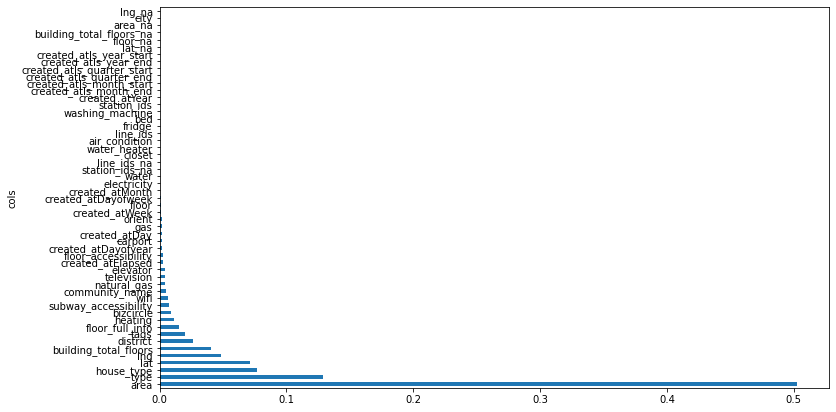

In [351]:
plot_fi(fi)

In [355]:
to_keep = fi[fi.imp>0.005].cols

In [356]:
len(to_keep)

13

In [357]:
to_keep

47                     area
21                     type
15               house_type
50                      lat
51                      lng
48    building_total_floors
7                  district
19                     tags
11          floor_full_info
14                  heating
2                 bizcircle
18     subway_accessibility
25                     wifi
Name: cols, dtype: object

In [331]:
fi.sort_values('imp')

,cols,imp
4,city,0.000000e+00
42,area_na,0.000000e+00
44,lng_na,0.000000e+00
43,lat_na,0.000000e+00
37,created_atIs_year_start,7.914296e-09
...,...,...
47,lng,4.797910e-02
46,lat,7.080351e-02
15,house_type,7.517846e-02
21,type,9.333878e-02


In [387]:
cont_nn, cat_nn = cont_cat_split(df_t, max_card=9000, dep_var=dep_var)

In [388]:
len(cont_nn)+len(cat_nn)

46

In [370]:
for c in ['station_ids','line_ids','building_total_floors','floor']:
    try:
        cont.remove(c)
        cat.append(c)
    except:
        print(c)

In [358]:
cols_to_keep = to_keep.to_numpy()

In [389]:
procs_nn = [Categorify, FillMissing, Normalize]
dls = TabularPandas(df_t, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var).dataloaders(1024)

In [390]:
learn = tabular_learner(dls, y_range=(6,12), layers=[500,250], n_out=1, loss_func=F.mse_loss, metrics=r_mse)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0003981071640737355)

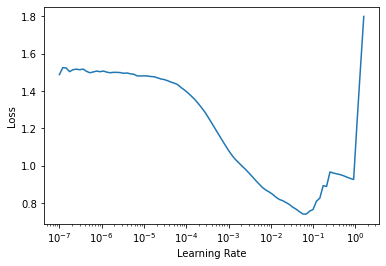

In [373]:
learn.lr_find()

In [391]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,r_mse,time
0,0.034554,0.047138,0.216264,00:21
1,0.025354,0.024555,0.156044,00:21
2,0.018948,0.022371,0.148652,00:21
3,0.014658,0.018545,0.135407,00:21
4,0.011502,0.017505,0.131591,00:21


In [381]:
df_t_c = df_t[[*to_keep,dep_var]]

In [385]:
cont_nn, cat_nn = cont_cat_split(df_t_c, max_card=9000, dep_var=dep_var)
procs_nn = [Categorify, FillMissing, Normalize]
dls = TabularPandas(df_t_c, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var).dataloaders(1024)
learn = tabular_learner(dls, y_range=(6,12), layers=[500,250], n_out=1, loss_func=F.mse_loss, metrics=r_mse)

In [386]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,r_mse,time
0,0.041797,0.044035,0.209216,00:11
1,0.038319,0.045762,0.213253,00:11
2,0.033302,0.048494,0.219166,00:11
3,0.029897,0.027460,0.165055,00:11
4,0.026516,0.027286,0.164588,00:11
5,0.025877,0.025525,0.159200,00:11
6,0.023368,0.025058,0.157617,00:11
7,0.021840,0.025568,0.159207,00:10
8,0.019995,0.024495,0.155839,00:11
9,0.018851,0.025534,0.159055,00:11


In [416]:
x = dls.train.one_batch()

In [418]:
x[0].shape, x[1].shape, x[2].shape

(torch.Size([1024, 45]), torch.Size([1024, 8]), torch.Size([1024, 1]))

In [411]:
learn.predict(.iloc[0])

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [420]:
preds, targ = learn.get_preds()

In [430]:
list(zip(preds[:10].exp(),targ[:10].exp()))

[(tensor([6390.0718]), tensor([6499.9985])),
 (tensor([38651.3828]), tensor([38000.0039])),
 (tensor([5865.7051]), tensor([5199.9985])),
 (tensor([3460.0237]), tensor([3500.0015])),
 (tensor([7600.5000]), tensor([7699.9995])),
 (tensor([5505.3037]), tensor([5599.9995])),
 (tensor([5641.6069]), tensor([4999.9980])),
 (tensor([5543.2622]), tensor([4999.9980])),
 (tensor([2059.3979]), tensor([1600.0001])),
 (tensor([25820.2793]), tensor([25999.9941]))]

In [441]:
dl = learn.dls.test_dl(df_t[-510:-500])
preds,_ = learn.get_preds(dl=dl)

In [445]:
list(zip(preds.exp(), tensor(df_t[-510:-500]['price'].to_numpy()).exp()))

[(tensor([2412.5493]), tensor(2500.0002)),
 (tensor([2657.1902]), tensor(2799.9998)),
 (tensor([6604.9219]), tensor(7199.9976)),
 (tensor([28606.9785]), tensor(37499.9883)),
 (tensor([2887.9351]), tensor(3000.0002)),
 (tensor([4309.1460]), tensor(4500.0005)),
 (tensor([22546.8730]), tensor(18000.0020)),
 (tensor([1937.5361]), tensor(2200.0002)),
 (tensor([14702.4287]), tensor(12799.9951)),
 (tensor([1495.2662]), tensor(1689.9998))]

In [449]:
learn.model.

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(3, 3)
    (2): Embedding(204, 31)
    (3): Embedding(4, 3)
    (4): Embedding(2, 2)
    (5): Embedding(3, 3)
    (6): Embedding(16720, 371)
    (7): Embedding(18, 8)
    (8): Embedding(4, 3)
    (9): Embedding(4, 3)
    (10): Embedding(3, 3)
    (11): Embedding(1357, 91)
    (12): Embedding(3, 3)
    (13): Embedding(4, 3)
    (14): Embedding(3, 3)
    (15): Embedding(285, 38)
    (16): Embedding(3, 3)
    (17): Embedding(153, 27)
    (18): Embedding(3, 3)
    (19): Embedding(915, 73)
    (20): Embedding(3, 3)
    (21): Embedding(3, 3)
    (22): Embedding(3, 3)
    (23): Embedding(4, 3)
    (24): Embedding(3, 3)
    (25): Embedding(3, 3)
    (26): Embedding(5, 4)
    (27): Embedding(13, 7)
    (28): Embedding(54, 15)
    (29): Embedding(32, 11)
    (30): Embedding(8, 5)
    (31): Embedding(367, 44)
    (32): Embedding(3, 3)
    (33): Embedding(3, 3)
    (34): Embedding(3, 3)
    (35): Embedding(3, 3)
    (